<a href="https://colab.research.google.com/github/stock-code/election_2016_twitter/blob/main/2016_Election_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#add code for remove url
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyLDAvis==2.1.2
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
df= pd.read_csv("/content/sample_data/2016_US_election_tweets_100k.csv")

df.head()

,id,candidate_id,tweet_id,polarity,subjectivity,retweet_count,favorite_count,device,retweeted_status_id,lang,state,tweet_text,created_at,inserted_at,updated_at,tw_user_id,latitude,longitude
0,57486,3,7.707290e+17,0.000000,0.000000,0,0,1,NaN,tr,NaN,"Ne farkınız var DAIŞ, El-Kaide, El Nusra, YPG ...",8/30/2016 21:03,8/30/2016 21:03,8/30/2016 21:03,NaN,NaN,NaN
1,57536,3,7.707290e+17,0.000000,0.000000,0,0,1,NaN,en,NaN,@BarackObama the way you showed up in Louisian...,8/30/2016 21:06,8/30/2016 21:06,8/30/2016 21:06,NaN,NaN,NaN
2,57586,3,7.707300e+17,-0.472222,0.555556,0,0,1,NaN,en,NaN,White house not taking tax avoid seriously! Ap...,8/30/2016 21:09,8/30/2016 21:09,8/30/2016 21:09,NaN,NaN,NaN
3,57632,2,7.707480e+17,0.000000,0.000000,0,0,0,NaN,en,NaN,"politico: .realDonaldTrump, HillaryClinton ple...",8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN
4,57682,1,7.707480e+17,-0.125000,0.375000,0,0,5,NaN,en,NaN,She's over due by 250 days. https://t.co/IfOO9...,8/30/2016 22:20,8/30/2016 22:20,8/30/2016 22:20,NaN,NaN,NaN


# New Section

In [ ]:
df.info()
df.drop(df.index[df['lang'] != 'en'], inplace = True)
df = df[df['tweet_text'].notna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   100000 non-null  int64  
 1   candidate_id         100000 non-null  int64  
 2   tweet_id             100000 non-null  float64
 3   polarity             100000 non-null  float64
 4   subjectivity         100000 non-null  float64
 5   retweet_count        100000 non-null  int64  
 6   favorite_count       100000 non-null  int64  
 7   device               100000 non-null  int64  
 8   retweeted_status_id  44607 non-null   float64
 9   lang                 91451 non-null   object 
 10  state                3279 non-null    object 
 11  tweet_text           55393 non-null   object 
 12  created_at           100000 non-null  object 
 13  inserted_at          100000 non-null  object 
 14  updated_at           100000 non-null  object 
 15  tw_user_id        

In [ ]:
df.info()
# Convert to list
data = df.tweet_text.values.tolist()
# remove url
data= [re.sub("https?:\/\/.*[\r\n]*", '',sent) for sent in data]
#remove mention
data=[re.sub("@[A-Za-z0-9]+","",sent) for sent in data]
#remove amp
data=[re.sub("amp","",sent) for sent in data]
data=[re.sub("#","",sent) for sent in data]
#remove_email
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
#remove less then 3 len
data = [sent for sent in data if len(sent)>3]

data=[re.sub("\'","",sent)for sent in data]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 46777 entries, 1 to 99999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   46777 non-null  int64  
 1   candidate_id         46777 non-null  int64  
 2   tweet_id             46777 non-null  float64
 3   polarity             46777 non-null  float64
 4   subjectivity         46777 non-null  float64
 5   retweet_count        46777 non-null  int64  
 6   favorite_count       46777 non-null  int64  
 7   device               46777 non-null  int64  
 8   retweeted_status_id  0 non-null      float64
 9   lang                 46777 non-null  object 
 10  state                2780 non-null   object 
 11  tweet_text           46777 non-null  object 
 12  created_at           46777 non-null  object 
 13  inserted_at          46777 non-null  object 
 14  updated_at           46777 non-null  object 
 15  tw_user_id           9753 non-null  

In [ ]:
#remove_punc
data=[sent.translate(str.maketrans('', '', string.punctuation)) for sent in data]
#remove_digit
data=[sent.translate(str.maketrans('', '', string.digits)) for sent in data]

In [ ]:
data[1:10]

['White house not taking tax avoid seriously Apple disgusting  AppleTax',
 'politico realDonaldTrump HillaryClinton pledge to pause caigns for  ',
 'Shes over due by  days ',
 'Eight Jamaicans selected for  ’s young leaders’ initiative ',
 ' can we just report the results after Election Day Polls dont mean anything in this election and  is a corrupt liar',
 'BarackObama Obama Obama commutes sentences for  more federal prisoners President Barac ',
 '  Trumpsters are all fools',
 '  And I see your VOTES sez HILLARY who only cares for MONEY AND POWER ANDHILLARY',
 'Let me sck ur dldo 👏  😘 Look my top tweet  whre ']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[9:11])

[['let', 'me', 'sck', 'ur', 'dldo', 'look', 'my', 'top', 'tweet', 'whre'], ['baldasaro', 'guess', 'calling', 'for', 'the', 'murder', 'of', 'has', 'its', 'upside']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['the', 'way', 'you', 'showed', 'up', 'in', 'louisiana']


In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['rt', 'retweet', 'lol', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    """https://spacy.io/api/annotation"""
    texts_out = []
    allowed_postags=['ADJ', 'VERB', 'ADV','NOUN']
    for sent in texts:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[:1])

[['show']]


In [ ]:
print(data_lemmatized[:10])
#print(data_lemGensim[:10])

[['show'], ['white_house', 'take', 'tax', 'avoid', 'seriously', 'apple', 'disgust', 'appletax'], ['pause_caign'], ['s', 'due', 'day'], ['select', 'young', 'leader'], ['report', 'result', 'election', 'day', 'poll', 'mean', 'election', 'corrupt', 'liar'], ['federal', 'prisoner'], ['trumpster', 'fool'], ['see', 'care', 'andhillary'], ['let', 'dldo', 'look', 'top']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('show', 1)],
 [('apple', 1),
  ('appletax', 1),
  ('avoid', 1),
  ('disgust', 1),
  ('seriously', 1),
  ('take', 1),
  ('tax', 1),
  ('white_house', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=20)
# Build LDA model
#lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=20)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"stupid" + 0.036*"word" + 0.032*"live" + 0.031*"stand" + '
  '0.026*"happen" + 0.026*"play" + 0.022*"high" + 0.020*"trump" + '
  '0.019*"world" + 0.018*"break"'),
 (1,
  '0.073*"love" + 0.062*"really" + 0.048*"people" + 0.034*"american" + '
  '0.027*"hide" + 0.027*"woman" + 0.026*"use" + 0.026*"put" + 0.019*"send" + '
  '0.017*"man"'),
 (2,
  '0.068*"thank" + 0.034*"supporter" + 0.033*"leave" + 0.022*"follow" + '
  '0.022*"hope" + 0.020*"away" + 0.017*"people" + 0.016*"child" + '
  '0.016*"white" + 0.015*"get"'),
 (3,
  '0.153*"go" + 0.046*"pay" + 0.035*"way" + 0.033*"help" + 0.032*"real" + '
  '0.028*"fact" + 0.023*"back" + 0.023*"ask" + 0.023*"s" + 0.022*"get"'),
 (4,
  '0.088*"want" + 0.070*"great" + 0.043*"trump" + 0.037*"create" + '
  '0.035*"election" + 0.030*"lose" + 0.028*"win" + 0.025*"next" + 0.025*"make" '
  '+ 0.024*"illegal"'),
 (5,
  '0.121*"job" + 0.071*"join" + 0.048*"delete" + 0.044*"mm_page" + '
  '0.025*"delusional" + 0.025*"have" + 0.022*"forget" + 0.0

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.715042051136587

Coherence Score:  0.3608425377990102


In [ ]:
# Visualize the topics
from pyLDAvis import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.164340  0.178369       1        1  6.308962
18    -0.107921 -0.196363       2        1  6.218766
8     -0.147086 -0.010986       3        1  5.873045
4      0.160790 -0.065617       4        1  5.871795
16    -0.152484  0.013344       5        1  5.481558
15     0.072898 -0.096402       6        1  5.450532
14     0.022089 -0.125183       7        1  5.198139
1     -0.125626 -0.045686       8        1  5.106892
6      0.033780 -0.077365       9        1  5.067193
13    -0.085964 -0.084085      10        1  5.032815
17    -0.074326  0.009990      11        1  4.779757
10     0.114959  0.154664      12        1  4.714754
2     -0.076038  0.048074      13        1  4.682740
12     0.060524  0.074480      14        1  4.677915
19     0.061416 -0.023303      15        1  4.640757
7      0.015060  0.215502      16        1  4.605909
11     0.088080 -0.047029      17        1  4.495146
0      0.085383 -0.015556      18        1  4.266343
9      0.037227  0.087414      19        1  3.932101
5      0.181577  0.005735      20        1  3.594882, topic_info=        Term         Freq        Total Category  logprob  loglift
90        be  2280.000000  2280.000000  Default  30.0000  30.0000
139       go  2215.000000  2215.000000  Default  29.0000  29.0000
76       say  2010.000000  2010.000000  Default  28.0000  28.0000
39       lie  1376.000000  1376.000000  Default  27.0000  27.0000
78      know  1468.000000  1468.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
539   afraid    66.476836    68.673677  Topic20  -4.7744   3.2931
1206   month    95.486462   109.761638  Topic20  -4.4123   3.1863
675     have   197.497207   367.674618  Topic20  -3.6856   2.7042
186    great   146.124978  1161.983325  Topic20  -3.9868   1.2522
56     trump    89.035376  2374.181856  Topic20  -4.4822   0.0423

[891 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
967       4  0.985480  absolutely
1296     12  0.988233      accept
1078     17  0.978059      accord
1951     10  0.989118     account
572       8  0.981273         act
...     ...       ...         ...
795      11  0.824470   yesterday
395       7  0.005092         yet
395      16  0.005092         yet
395      17  0.987804         yet
15       14  0.971217       young

[1668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 19, 9, 5, 17, 16, 15, 2, 7, 14, 18, 11, 3, 13, 20, 8, 12, 1, 10, 6])

In [ ]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

--2021-04-12 23:59:56--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  17.9MB/s    in 0.9s    

2021-04-12 23:59:57 (17.9 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from gensim.models.wrappers import LdaMallet
import os.path

mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
gensimmodel30 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


In [ ]:
# Show Topics
pprint(gensimmodel30.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=gensimmodel30, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('president', 0.060663061368445806),
   ('run', 0.047966141547143196),
   ('word', 0.03891370797084411),
   ('person', 0.03280037620503174),
   ('leader', 0.025628967787444158),
   ('forget', 0.024453327063249472),
   ('head', 0.021631789325182223),
   ('move', 0.021514225252762757),
   ('dumb', 0.020573712673407008),
   ('fight', 0.0202210204561486)]),
 (7,
  [('trump', 0.27031823021412515),
   ('job', 0.1484679995267952),
   ('join', 0.10434165385070389),
   ('thousands_reminding', 0.04317993611735479),
   ('create', 0.038921093103040344),
   ('member', 0.022713829409677037),
   ('mm_page', 0.02153081746125636),
   ('hire', 0.013368035017153673),
   ('economy', 0.010292203951259907),
   ('company', 0.009937300366733704)]),
 (19,
  [('plan', 0.0628718068354135),
   ('illegal', 0.0527236673276566),
   ('wall', 0.04770792021462732),
   ('hear', 0.047008048524437185),
   ('build', 0.04269217310159804),
   ('law', 0.04210894669310626),
   ('vote', 0.037326490143473695),
   ('immig

In [ ]:
def compute_coherence_values_LDA(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA  topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      model=gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics,id2word=id2word)
      #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_LDA(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

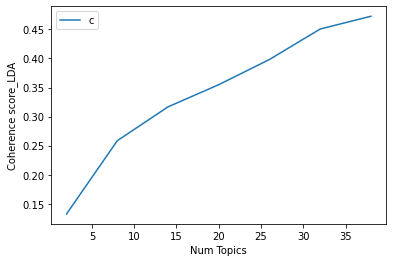

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score_LDA")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA Mallet topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
      #model=gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics,id2word=id2word)
      model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
      model_list.append(model)
      coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
      coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values_MALLET = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

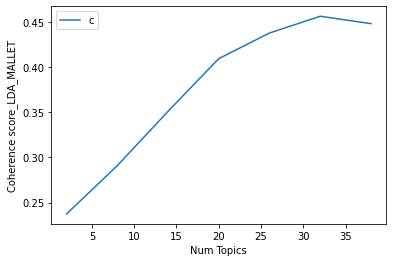

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_MALLET)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score_LDA_MALLET")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores LDA
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1325
Num Topics = 8  has Coherence Value of 0.2585
Num Topics = 14  has Coherence Value of 0.3168
Num Topics = 20  has Coherence Value of 0.3549
Num Topics = 26  has Coherence Value of 0.3983
Num Topics = 32  has Coherence Value of 0.4507
Num Topics = 38  has Coherence Value of 0.4727


In [ ]:
# Print the coherence scores LDA
for m, cv in zip(x, coherence_values_MALLET):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2375
Num Topics = 8  has Coherence Value of 0.2908
Num Topics = 14  has Coherence Value of 0.3509
Num Topics = 20  has Coherence Value of 0.4092
Num Topics = 26  has Coherence Value of 0.4375
Num Topics = 32  has Coherence Value of 0.4561
Num Topics = 38  has Coherence Value of 0.4479


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.085*"love" + 0.075*"country" + 0.041*"run" + 0.039*"tweet" + 0.037*"put" '
  '+ 0.035*"state" + 0.025*"guy" + 0.021*"caign" + 0.020*"free" + '
  '0.017*"poor"'),
 (1,
  '0.079*"show" + 0.060*"poll" + 0.050*"fact" + 0.034*"turn" + 0.030*"happen" '
  '+ 0.027*"check" + 0.025*"lead" + 0.023*"nice" + 0.020*"kid" + '
  '0.019*"reality"'),
 (2,
  '0.069*"talk" + 0.045*"wait" + 0.044*"debate" + 0.033*"point" + '
  '0.031*"today" + 0.030*"issue" + 0.026*"leader" + 0.019*"meet" + '
  '0.017*"high" + 0.017*"low"'),
 (3,
  '0.096*"support" + 0.051*"illegal" + 0.038*"liar" + 0.032*"kill" + '
  '0.032*"family" + 0.029*"candidate" + 0.026*"criminal" + 0.021*"deport" + '
  '0.019*"fire" + 0.016*"crooked"'),
 (4,
  '0.151*"job" + 0.077*"join" + 0.050*"lose" + 0.044*"thousands_reminding" + '
  '0.037*"give" + 0.036*"stand" + 0.022*"elect" + 0.015*"fraud" + '
  '0.014*"loser" + 0.012*"raise"'),
 (5,
  '0.172*"vote" + 0.051*"truth" + 0.048*"hear" + 0.042*"bring" + '
  '0.033*"change" + 0.032*"s